Initializing staff

In [1]:
import numpy as np
import scipy.integrate as integrate
import lhapdf
import ROOT

Welcome to JupyROOT 6.29/01


Setting up constants

In [2]:
s_h = 27**2 # in GeV (TeV)
p_t = [1,2,3,4]#[0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00] #GeV
i_ = [-4,-3,-2,-1,1,2,3,4]
j_ = [-4,-3,-1,-2,2,1,3,4]
alpha_em=1./137

Setting up pdf sets

In [3]:
pdfs = [lhapdf.mkPDF("NNPDF23_nlo_as_0118", 0), lhapdf.mkPDF("nNNPDF20_nlo_as_0118_D2", 0), lhapdf.mkPDF("cteq6l1", 0)]

LHAPDF 6.5.4 loading /home/yoren/bnl/lhapdf/LHAPDF-6.5.4/install/share/LHAPDF/NNPDF23_nlo_as_0118/NNPDF23_nlo_as_0118_0000.dat
NNPDF23_nlo_as_0118 PDF set, member #0, version 6; LHAPDF ID = 229800
LHAPDF 6.5.4 loading /home/yoren/bnl/lhapdf/LHAPDF-6.5.4/install/share/LHAPDF/nNNPDF20_nlo_as_0118_D2/nNNPDF20_nlo_as_0118_D2_0000.dat
nNNPDF20_nlo_as_0118_D2 PDF set, member #0, version 1; LHAPDF ID = 30010300
LHAPDF 6.5.4 loading /home/yoren/bnl/lhapdf/LHAPDF-6.5.4/install/share/LHAPDF/cteq6l1/cteq6l1_0000.dat
cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042


Function for Compton and annihilation cross-section

Setting up Histos

In [4]:
hist = ROOT.TH1D("hist","hist",1000,0,0.1)

In [5]:
def compton_anih_crossection(y_2, y_1, p, iset1, iset2, isospin1, isospin2):

    #if y_1<0: print("WTF")
    if abs(y_1)>2 or y_2>2: return 0.
        
    x_1 = (2*p/np.sqrt(s_h))* np.exp((y_1 + y_2)/2)*np.cosh(abs((y_1-y_2)/2))
    x_2 = (2*p/np.sqrt(s_h))* np.exp(-(y_1 + y_2/2))*np.cosh(abs((y_1-y_2)/2))
    hist.Fill(x_1*x_2)
    s = x_1*x_2*s_h
    
    if np.all( [x_1 > 0 , x_1 < 1 , x_2 > 0 , x_2 < 1, 1. - 4*(p)**2/s > 0] ):
        
        cos_theta = np.sqrt(1 - 4*(p)**2/s)
        u = (-1*s/2)*(1 + cos_theta)
        t = (-1*s/2)*(1 - cos_theta)
        Q2 = -t
        
        pdf1 = pdfs[iset1]
        pdf2 = pdfs[iset2]
        alpha_s = 0.5*(pdf1.alphasQ2(Q2)+pdf2.alphasQ2(Q2))

        sigma=0.
        for iquark in range(len(i_)):
            i1, i2 = i_[iquark], i_[iquark]
            if isospin1==1: i1 = j_[iquark]
            if isospin2==1: i2 = j_[iquark]
            
            eq2 = (1. + (i_[iquark]+1)%2)**2/9.
            
            pdf_i = max(pdf1.xfxQ2(i1, x_1, Q2)/x_1,0.)
            pdf_j = max(pdf2.xfxQ2(21, x_2, Q2)/x_2,0.)
            pdf_k = max(pdf2.xfxQ2(-i2, x_2, Q2)/x_2,0.)
            pdf_i2 = max(pdf2.xfxQ2(i2, x_2, Q2)/x_2,0.)
            pdf_j2 = max(pdf1.xfxQ2(21, x_1, Q2)/x_1,0.)
        
            sigma_compton_dt = -eq2*(8*np.pi*alpha_s*alpha_em/s)*((s**2 + u**2)/(4*u*s))

            sigma_anihhil_dt = -eq2*(8*np.pi*alpha_s*alpha_em/s)*((t**2 + u**2)/(4*t*s))
            
            sigma += pdf_i*pdf_j*sigma_compton_dt + pdf_i2*pdf_j2*sigma_compton_dt
            sigma += pdf_i*pdf_k*sigma_anihhil_dt
        
        return  sigma
    return 0.

$\tau=x_1\cdot x_2$, $y=(1/2)ln{x_1/x_2}$

In [6]:
def compton_anih_crossection1(y, tau, p, iset1, iset2, isospin1, isospin2):

    print(y, tau)
    x_1 = np.sqrt(tau) * np.exp(+y)
    x_2 = np.sqrt(tau) * np.exp(-y)
    
    #hist.Fill(x_1*x_2)
    s = x_1*x_2*s_h
    
    if np.all( [x_1 > 0 , x_1 < 1 , x_2 > 0 , x_2 < 1, 1. - 4*(p)**2/s > 0] ):
        
        cos_theta = np.sqrt(1 - 4*(p)**2/s)
        u = (-1*s/2)*(1 + cos_theta)
        t = (-1*s/2)*(1 - cos_theta)
        Q2 = -t
        
        pdf1 = pdfs[iset1]
        pdf2 = pdfs[iset2]
        alpha_s = 0.5*(pdf1.alphasQ2(Q2)+pdf2.alphasQ2(Q2))

        sigma=0.
        for iquark in range(len(i_)):
            i1, i2 = i_[iquark], i_[iquark]
            if isospin1==1: i1 = j_[iquark]
            if isospin2==1: i2 = j_[iquark]
            
            eq2 = (1. + (i_[iquark]+1)%2)**2/9.
            
            pdf_i = max(pdf1.xfxQ2(i1, x_1, Q2)/x_1,0.)
            pdf_j = max(pdf2.xfxQ2(21, x_2, Q2)/x_2,0.)
            pdf_k = max(pdf2.xfxQ2(-i2, x_2, Q2)/x_2,0.)
            pdf_i2 = max(pdf2.xfxQ2(i2, x_2, Q2)/x_2,0.)
            pdf_j2 = max(pdf1.xfxQ2(21, x_1, Q2)/x_1,0.)
        
            sigma_compton_dt = -eq2*(8*np.pi*alpha_s*alpha_em/s)*((s**2 + u**2)/(4*u*s))

            sigma_anihhil_dt = -eq2*(8*np.pi*alpha_s*alpha_em/s)*((t**2 + u**2)/(4*t*s))
            
            sigma += pdf_i*pdf_j*sigma_compton_dt + pdf_i2*pdf_j2*sigma_compton_dt
            sigma += pdf_i*pdf_k*sigma_anihhil_dt
        
        return  sigma
    return 0.

Testing

In [7]:
print(compton_anih_crossection(0.01,0.5,1,0,0,0,0))

0.0


Integration Bounds and accuracy

In [8]:
def bounds_y(p, iset1, iset2, isospin1, isospin2):
    return [np.log(p/np.sqrt(s_h)), np.log(np.sqrt(s_h)/p)]
        
def bounds_x(y_1, p, iset1, iset2, isospin1, isospin2):
    return [np.log(p/(np.sqrt(s_h) - p*np.exp(-y_1))), np.log((np.sqrt(s_h) - p*np.exp(-y_1))/p)]

def bounds_y1(p, iset1, iset2, isospin1, isospin2):
    return [4.*p**2/s_h, 1]
        
def bounds_x1(tau, p, iset1, iset2, isospin1, isospin2):
    return [-0.5*abs(np.log(tau)), -0.5*abs(np.log(tau))]
    
def opts0(y_1, p, iset1, iset2, isospin1, isospin2):
    return {'epsrel' : 0.05}

def opts1(p, iset1, iset2, isospin1, isospin2):
    return {'epsrel' : 0.05}                

Integration function

In [9]:
def integration_cs(pT,iset1,iset2,isospin1,isopin2):
    result=[]
    for p in pT:
        integral = integrate.nquad(compton_anih_crossection, [bounds_x, bounds_y], args=[p,iset1,iset2,isospin1,isopin2], opts=[opts0,opts1])
        #print(p,i,integral)
        result.append(integral)   
                
    return result

Parallel calculating for $p+p$

Drawing histos

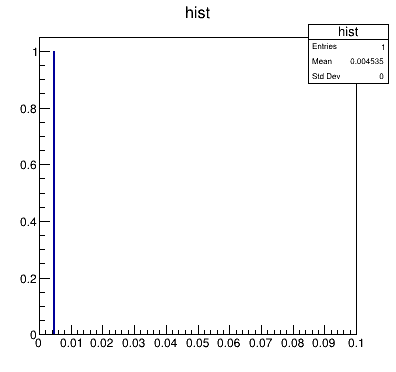

In [10]:
c1 = ROOT.TCanvas("c1","c1",400,400)
hist.Draw()
c1.Draw()
#%jsroot on

In [11]:
import multiprocess as mp

Ntr = 4
pool = mp.Pool(Ntr)

hist_array = pool.starmap(integration_cs, ([[1.0*i+1.0], 0,0,0,0] for i in range(Ntr)))
    
pool.close()   

Parallel calculating for $p+n$

In [12]:
pool_pn = mp.Pool(Ntr)

hist_array_pn = pool_pn.starmap(integration_cs, [([1.0*i+1.0], 0,0,0,1) for i in range(Ntr)])
    
pool.close()   

Parallel calculating for $n+p$

In [13]:
pool_np = mp.Pool(Ntr)

hist_array_np = pool_np.starmap(integration_cs, [([1.0*i+1.0], 0,0,1,0) for i in range(Ntr)])
    
pool.close()   

Parallel calculating for $n+n$

In [14]:
pool_nn = mp.Pool(Ntr)

hist_array_nn = pool_nn.starmap(integration_cs, [([1.0*i+1.0], 0,0,1,1) for i in range(Ntr)])
    
pool.close()   

Parallel calculating for $d+d$

In [15]:
pool_dd = mp.Pool(Ntr)

hist_array_dd = pool_dd.starmap(integration_cs, [([1.0*i+1.0], 1,1,0,0) for i in range(Ntr)])
    
pool.close()   

In [ ]:
pool_pd = mp.Pool(Ntr)

hist_array_pd = pool_pd.starmap(integration_cs, [([1.0*i+1.0], 1,0,0,0) for i in range(Ntr)])
    
pool.close()   

pool_dp = mp.Pool(Ntr)

hist_array_dp = pool_dp.starmap(integration_cs, [([1.0*i+1.0], 0,1,0,0) for i in range(Ntr)])
    
pool.close()   

In [ ]:
print(hist_array_pd)
print(hist_array_dp)

Factors

In [ ]:
print(hist_array_pn)
print(hist_array_)
res_iso=[]
for ival in range(len(hist_array)):
    res_iso.append(0.25*(hist_array[ival][0][0]+hist_array_pn[ival][0][0]+hist_array_np[ival][0][0]+hist_array_nn[ival][0][0])/(hist_array[ival][0][0]+1e-20))
print("pT:1.0,2.0,3.0,4.0",res_iso)
res=[]
for ival in range(len(hist_array)):
    res.append(hist_array_dd[ival][0][0]/(hist_array[ival][0][0]+1e-20))
print("pT:1.0,2.0,3.0,4.0",res)